In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# df = pd.read_excel("../models/data/EsaveExportSmall.xls") # for github and small dataset
df = pd.read_excel("../../EsaveExportBig.xls") # local file. use above if not you are not me
df.rename(columns={df.columns[0]: "datetime"}, inplace=True)
datetime = df.pop("datetime")
df = df.dropna(axis=1, how="any")
df = df.applymap(lambda cell: float(str(cell).replace(",", ".")))
channels = df.shape[1] # for later
print(channels)
df

81


,707057500068119547,707057500068755066,ESAVE_193681-980396002_EAN,707057500068789658,707057500068425556,707057500068402960,707057500068104048,707057500068744237,707057500068750269,707057500067764427,...,707057500068094592,707057500068742943,ESAVE_182900-980396002_EAN,707057500068702657,707057500068298990,707057500068614882,707057500068762040,707057500068392667,ESAVE_66267-980396002_EAN,707057500068415243
0,9.4,7.2,8.0,7.1,4.0,6.7,9.9,14.6,4.7,4.7,...,3.2,2.6,13.0,8.0,7.0,6.9,5.4,1.6,8.0,4.6
1,9.6,7.2,9.0,7.0,7.0,8.6,10.0,14.6,2.9,3.8,...,3.2,2.8,12.0,6.5,8.0,7.8,5.0,1.8,9.0,4.7
2,8.7,7.2,9.0,6.2,6.0,10.4,8.8,15.0,3.2,4.0,...,3.4,2.6,14.0,7.7,7.2,8.8,5.4,2.0,8.0,4.6
3,8.8,7.2,9.0,7.8,5.0,10.2,10.2,16.6,5.3,3.8,...,3.2,2.8,12.0,6.7,7.2,9.4,4.6,1.9,7.0,5.0
4,9.1,7.2,9.0,7.0,5.0,9.8,9.9,15.4,18.2,4.2,...,3.4,2.6,13.0,5.6,7.4,20.8,15.2,1.9,8.0,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43843,6.0,3.0,7.0,3.0,7.0,7.0,10.0,16.0,2.0,6.0,...,3.0,5.0,10.0,6.0,6.0,7.0,17.0,2.0,8.0,4.0
43844,7.0,2.0,6.0,6.0,6.0,7.0,11.0,15.0,3.0,7.0,...,4.0,5.0,11.0,8.0,4.0,8.0,16.0,1.0,8.0,5.0
43845,6.0,3.0,6.0,4.0,7.0,10.0,11.0,16.0,2.0,8.0,...,3.0,6.0,10.0,8.0,4.0,8.0,9.0,2.0,9.0,4.0
43846,7.0,3.0,7.0,6.0,6.0,13.0,11.0,16.0,3.0,7.0,...,3.0,5.0,11.0,7.0,5.0,11.0,19.0,3.0,8.0,5.0


4.901496020809273


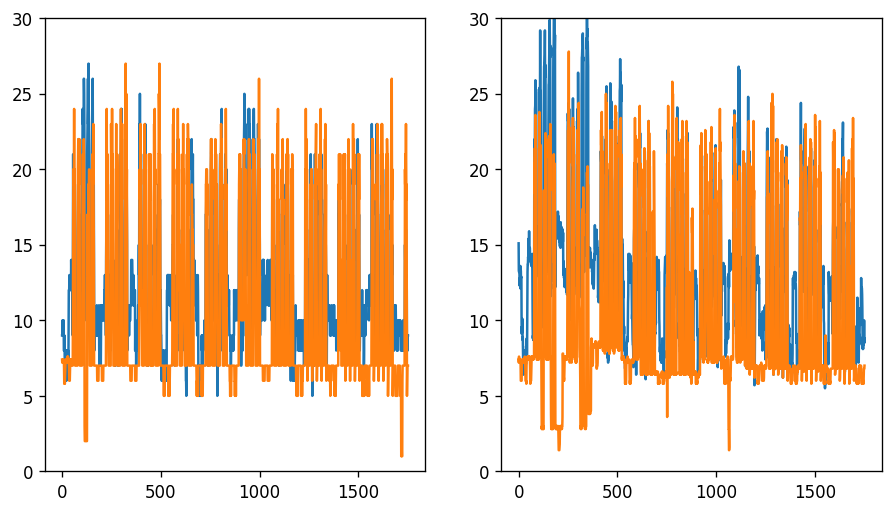

In [4]:
year = 24*365

plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
fig, ax = plt.subplots(1,2)
ax[0].set_ylim([0,30])
ax[1].set_ylim([0,30])

start_idx = 2*year
end_idx = int(2*year*1.1)

actual = df.iloc[start_idx:end_idx,:2].values # last argument is channels/meters shown
prediction = df.iloc[start_idx-year:end_idx-year,:2].values # same days last year

rms = ((actual - prediction)**2).mean()**0.5
print(rms)
ax[0].plot(actual) # the correct data
ax[1].plot(prediction)
plt.show()

# class to help merge anomalies together

In [5]:
class Anomaly:
    def __init__(self, name, start, end):
        self.name = name
        self.start = start
        self.end = end
        
    # same anomaly if they had the difference in interval is max 1 day from start and end
    def __eq__(self, other):
        if not isinstance(other, Anomaly):
            return False
        return self.name == other.name and abs(self.start - other.start) <= 48 and abs(self.end - other.end) <= 48
    
    def update(self, other):
        self.end = other.end
        
    def __repr__(self):
        return f"({self.name}, start={self.start}, end={self.end})"
    
    def __iter__(self):
        return iter((self.name, self.start, self.end))
    

        
an1 = Anomaly(2, 17602,17702)
an2 = Anomaly(2, 17603,17703)
an3 = Anomaly(2, 20,30)
x,y,z = an3
print(x,y,z)
print(an1 == an2)
print(an2 in [an1])
print(an2 in [an3])

2 20 30
True
True
False


# find anomaly intervals

In [6]:
anomaly_interval = 48 # hours of intervals to check for abnormal periods
all_anomalies = []

for i in range(2*year, 4*year):
    actual = df.iloc[i:i+anomaly_interval,:10].values # in reality this would be the live data
    prediction = df.iloc[i-year:i-year+anomaly_interval,:10].values # prediction based on last year
    rms = ((actual - prediction)**2).mean(axis=0)**0.5
    anomalies = np.argwhere(rms > 30)
    # merges together anomalies
    if anomalies.any():
        for anomaly in anomalies.tolist():
            anomaly = Anomaly(anomaly[0], i ,i+anomaly_interval)
            if anomaly not in all_anomalies:
                all_anomalies.append(anomaly)
            else:
                idx = all_anomalies.index(anomaly)
                all_anomalies[idx].update(anomaly)
                          
    # if the above is confusing, uncomment line below to see how it originally was
    #print(f"anomaly at channels: {anomalies.tolist()}. at time interval [{i,i+anomaly_interval}]")
    
print(all_anomalies)

[(2, start=17657, end=17742), (7, start=28129, end=28200)]


# plot cause of detection (big error from prediction)

4.679298380455486 10.13615361736175


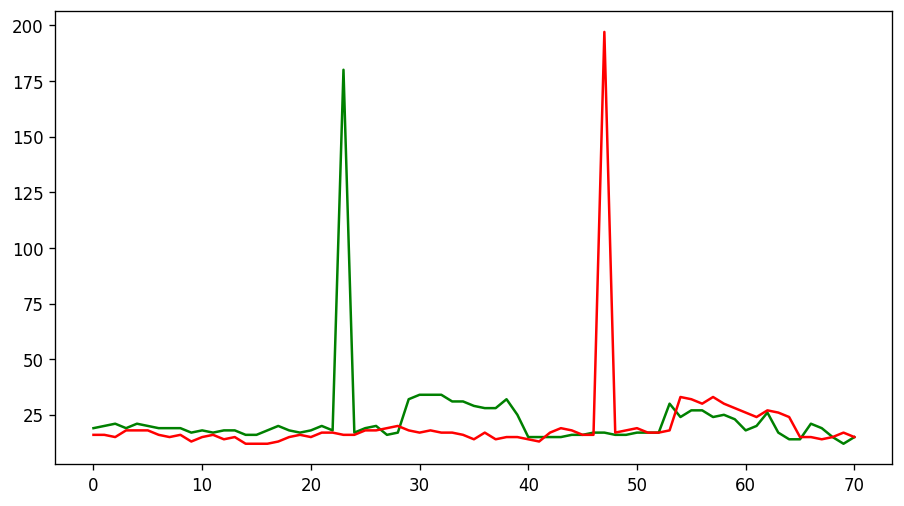

In [7]:
channel, start_idx, end_idx = all_anomalies[1]

actual = df.iloc[start_idx:end_idx].values # last argument is channels/meters shown
prediction = df.iloc[start_idx-year:end_idx-year].values # same days last year

rms_channel = ((actual - prediction)**2).mean(axis=0)**0.5
rms_total = ((actual - prediction)**2).mean()**0.5
print(rms[channel], rms_total)

plt.plot(actual[:,channel], color="green")
plt.plot(prediction[:,channel], color="red")
plt.show()

# plot actual data in bigger period to see if it really was abnormal

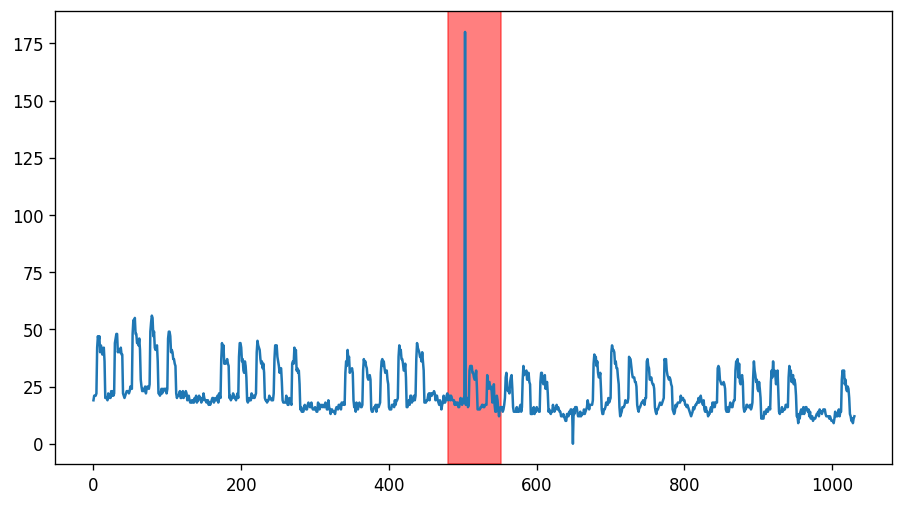

In [8]:
# 30 days before and after anomaly included
padding = 24*20
actual = df.iloc[start_idx-padding:end_idx+padding,channel].values
interval = end_idx - start_idx
plt.plot(actual)
plt.axvspan(padding, padding+interval, color='red', alpha=0.5)
plt.show()